# ABS Inflation model

Aim: to forecasr the next trimmed mean (TM) print based on ...
- upstream inflation PPI
- prevaiing cost pressures WPI
- the Phillips curve (inflation and unemployment have an inverse relationship) UER)
- previous quarter TM, as the series is autocorrelated. 

## Python set-up

In [1]:
# system imports
from math import isfinite

# analytic imports
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import readabs as ra

In [2]:
# local imports
from abs_helper import QUARTERLY_CPI_RANGE
from plotting import line_plot, finalise_plot, set_chart_dir, clear_chart_dir
from henderson import hma

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/Inflation-Model/"
set_chart_dir(CHART_DIR)
clear_chart_dir(CHART_DIR)

# display charts in this notebook
SHOW = True

## Data capture

 ### Identify the data we want to use

In [4]:
def get_data() -> tuple[dict[str, pd.Series], pd.DataFrame]:
    """Get a dictionary of data items from the ABS."""

    wanted = {
        # "Series ID": ["Category ID", "single-excel-only table name", "Short Series Title"],
        "A3604510W": ["6401.0", "640106", "CPI_TM"],  # change from previous quarter
        "A2314867K": ["6427.0", "642701", "PPI"],  # change from previous year
        "A83895396W": ["6345.0", "634501", "WPI"],  # change from previous year
        "A84423050A": ["6202.0", "6202001", "UER"],  # percent of labour force
    }

    data, meta = {}, {}
    for series_id, (category_id, seo, title) in wanted.items():
        d, m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        data[title] = d[series_id]
        meta[title] = m.loc[series_id]
    return data, pd.DataFrame(meta).T


_, META = get_data()
# check we have the correct variables
# META

### Collect and marshall that data
Assume we are only doind a one period prediction

In [5]:
def collect_data(subs: dict | None = None) -> tuple[pd.DataFrame, pd.Index, pd.Series]:
    """Collect the data for the inflation model.
    Arguments:
        subs: Dictionary of substitutions for forward values
    Returns:
        data: DataFrame containing the data
        exogenous: Index of exogenous variable names
        endogenous: Series of endogenous variables (ie CPI_TM)"""

    data_dict, meta = get_data()
    data_dict["UER"] = ra.monthly_to_qtly(data_dict["UER"])
    data = pd.concat(data_dict, axis=1)

    # forward for one period prediction
    last = data.loc[data.index[-1], "CPI_TM"]
    if isfinite(last):
        next = data.index[-1] + 1
        new_index = data.index.append(pd.PeriodIndex([next]))
        data = data.reindex(new_index)

    # populate forward exogenous guesses into the model
    last = data.index[-1]
    if subs is not None:
        for k, v in subs.items():
            if subs == "CPI_TM" or isfinite(data.loc[last, k]):
                continue
            data.loc[last, k] = v

    # Adjust missing values in PPI and WPI because they are published after CPI
    # so we may need rolling average approximations to plug in
    for s in ("PPI", "WPI"):
        "Do noting if next lines commented out ..."
        data[f"{s}_ADJ"] = data[s].where(
            data[s].notna(), other=data[s].rolling(4).mean().ffill()
        )
        # data = data.drop(columns=s)

    # smooth WPI/PPI
    h = 7
    for s in ("WPI", "PPI"):
        "Do noting if next lines commented ..."
        data[f"{s}_HMA[{h}]"] = hma(data[f"{s}_ADJ"].dropna(), h)

    # provide differences
    for col in ("PPI_ADJ", "WPI_ADJ", "UER"):
        data[f"Δ{col}"] = data[f"{s}_ADJ"].diff(1)

    # add autoregression
    for ar in (1, 2):
        data[f"CPI_TM-{ar}"] = data["CPI_TM"].shift(ar)

    # add the constant
    data["const"] = 1.0

    # Add a COVID dummy
    data["covid"] = 0
    data.loc["2022Q1":"2023Q1", "covid"] = 1

    # remove early nans
    remember = data.iloc[-1]
    data = pd.concat([data.dropna(), remember.to_frame().T])

    # exogenous and out-of-sample endogenous where known variables
    exogenous = data.columns.difference(["CPI_TM"])
    endogenous = data.index[-1]
    return data, exogenous, endogenous


DATA, EXOG, ENDOG = collect_data(subs={"UER": 4.1, "WPI": 4.0, "PPI": 4.3})
DATA.tail()

,CPI_TM,PPI,WPI,UER,PPI_ADJ,WPI_ADJ,WPI_HMA[7],PPI_HMA[7],ΔPPI_ADJ,ΔWPI_ADJ,ΔUER,CPI_TM-1,CPI_TM-2,const,covid
2023Q2,0.9,3.9,3.7,3.598759,3.9,3.7,3.770490,4.117343,-1.000,-1.000,-1.000,1.2,1.7,1.0,0.0
2023Q3,1.2,3.8,4.0,3.683085,3.8,4.0,3.994126,3.880769,-0.100,-0.100,-0.100,0.9,1.2,1.0,0.0
2023Q4,0.8,4.1,4.2,3.884424,4.1,4.2,4.117762,3.995734,0.300,0.300,0.300,1.2,0.9,1.0,0.0
2024Q1,1.0,4.3,4.1,3.893204,4.3,4.1,4.109752,4.151914,0.200,0.200,0.200,0.8,1.2,1.0,0.0
2024Q3,NaN,4.3,4.0,4.100000,4.3,4.0,3.975287,4.215075,0.275,0.275,0.275,0.8,1.0,1.0,0.0


In [6]:
EXOG

Index(['CPI_TM-1', 'CPI_TM-2', 'PPI', 'PPI_ADJ', 'PPI_HMA[7]', 'UER', 'WPI',
       'WPI_ADJ', 'WPI_HMA[7]', 'const', 'covid', 'ΔPPI_ADJ', 'ΔUER',
       'ΔWPI_ADJ'],
      dtype='object')

In [7]:
ENDOG

Period('2024Q3', 'Q-DEC')

## Build a simple multiple regression model

In [8]:
forecasts = {}


def run_model(data, exog: list[str], title: str, endog: pd.Series | None):

    # Fit the model
    y = data["CPI_TM"].dropna()
    X = data.loc[y.index, exog]
    Xnew = data.loc[data.index.difference(X.index), exog]
    model = sm.OLS(y, X)
    fit = model.fit()
    print(fit.summary())

    # QQ plot
    fig = sm.qqplot(fit.resid, line="s")
    name = title.split(" vs ")[1].rsplit(" ", 1)[0]
    finalise_plot(
        fig.axes[0],
        title=f"QQ Plot: {name}",
        xlabel="Theoretical Quantiles",
        ylabel="Sample Quantiles",
        show=SHOW,
    )

    # can we forecast?
    can_forecast = endog is not None and len(Xnew) > 0
    if can_forecast:
        print("Forecasting using:")
        display(Xnew)
        ynewpred = fit.predict(Xnew)  # predict out of sample
        display(ynewpred)
        forecasts[title] = ynewpred.iloc[0]
        ynewpred[y.index[-1]] = y.iloc[-1]  # start from actual
        quarterly = ynewpred.iloc[1]
        annual = (
            (((pd.concat([y.iloc[-3:-1], ynewpred]) / 100) + 1).cumprod() - 1) * 100
        ).iloc[-1]
        projection = (
            f"Projection {ynewpred.index[-1]}: A:{annual:.2f}% Q:{quarterly:.2f}%"
        )
    projection = projection if can_forecast else ""

    # plot avtual vs predicted
    m = [f"({x}*{round(y, 3)})" for x, y in fit.params.items()]
    m = "ypred = " + " + ".join(m)
    ypred = fit.predict(X)
    model_frame = pd.DataFrame({"Actual": y, "Within sample predicted": ypred})
    if can_forecast:
        model_frame = model_frame.reindex(model_frame.index.union(ynewpred.index))
        model_frame["Out of sample forecast"] = ynewpred
    line_plot(
        model_frame,
        title=title,
        ylabel="Inflation % per quarter",
        color=("cornflowerblue", "darkorange", "darkred"),
        width=(1.5, 2, 3),
        axhspan=QUARTERLY_CPI_RANGE,
        lfooter=m if len(m) < 80 else "",
        y0=True,
        show=SHOW,
    )

                            OLS Regression Results                            
Dep. Variable:                 CPI_TM   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     24.57
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           1.81e-20
Time:                        13:27:58   Log-Likelihood:                 39.122
No. Observations:                  98   AIC:                            -58.24
Df Residuals:                      88   BIC:                            -32.39
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CPI_TM-1       0.1591      0.108      1.472      0.1

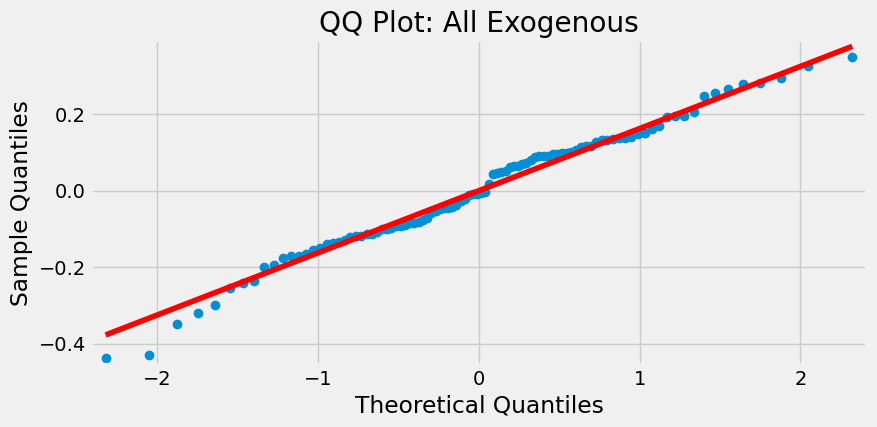

Forecasting using:


,CPI_TM-1,CPI_TM-2,PPI,PPI_ADJ,PPI_HMA[7],UER,WPI,WPI_ADJ,WPI_HMA[7],const,covid,ΔPPI_ADJ,ΔUER,ΔWPI_ADJ
2024Q3,0.8,1.0,4.3,4.3,4.215075,4.1,4.0,4.0,3.975287,1.0,0.0,0.275,0.275,0.275


2024Q3    0.868067
Freq: Q-DEC, dtype: float64

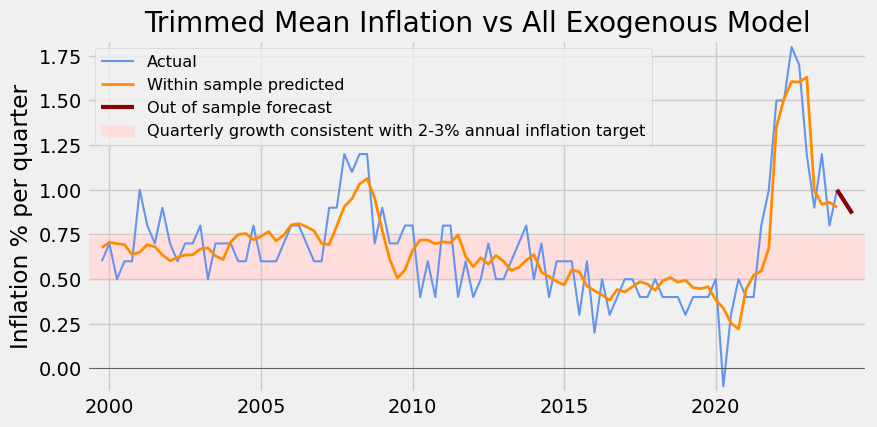

In [9]:
# Simple everything model
title = "Trimmed Mean Inflation vs All Exogenous Model"
run_model(DATA, EXOG.to_list(), title, ENDOG)

                            OLS Regression Results                            
Dep. Variable:                 CPI_TM   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     49.10
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           3.86e-22
Time:                        13:27:59   Log-Likelihood:                 33.189
No. Observations:                  98   AIC:                            -56.38
Df Residuals:                      93   BIC:                            -43.45
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CPI_TM-1       0.2655      0.105      2.531      0.0

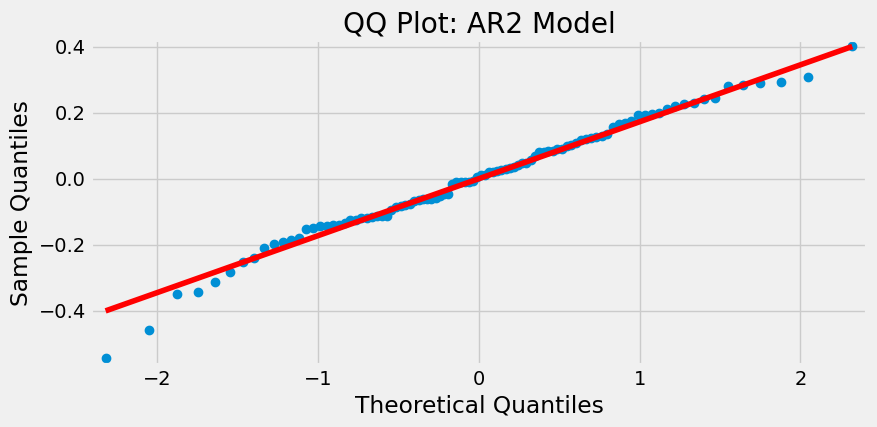

Forecasting using:


,CPI_TM-1,CPI_TM-2,PPI_HMA[7],const,covid
2024Q3,0.8,1.0,4.215075,1.0,0.0


2024Q3    0.841824
Freq: Q-DEC, dtype: float64

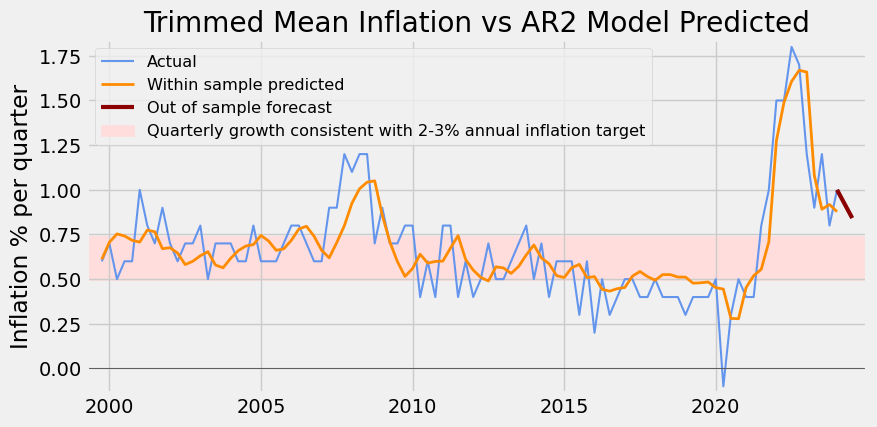

In [10]:
# REMOVE some cooefficients that are not significantly different from zero
exog = EXOG.difference(
    [
        "WPI",
        "WPI_ADJ",
        "WPI_HMA[7]",
        "PPI",
        "PPI_ADJ",
        "UER",
        "ΔPPI_ADJ",
        "ΔUER",
        "ΔWPI_ADJ",
    ]
)
title = "Trimmed Mean Inflation vs AR2 Model Predicted"
run_model(DATA, exog, title, ENDOG)

                            OLS Regression Results                            
Dep. Variable:                 CPI_TM   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     57.14
Date:                Thu, 01 Aug 2024   Prob (F-statistic):           4.09e-21
Time:                        13:27:59   Log-Likelihood:                 28.423
No. Observations:                  98   AIC:                            -48.85
Df Residuals:                      94   BIC:                            -38.51
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CPI_TM-1       0.4646      0.086      5.382      0.0

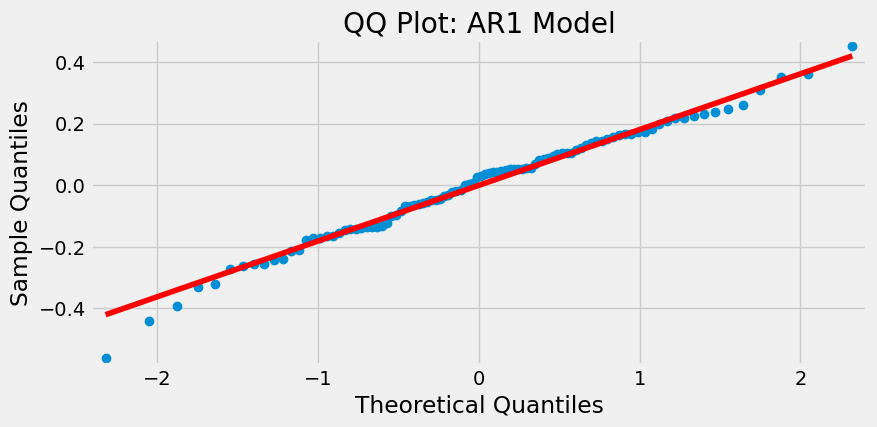

Forecasting using:


,CPI_TM-1,UER,covid,const
2024Q3,0.8,4.1,0.0,1.0


2024Q3    0.811262
Freq: Q-DEC, dtype: float64

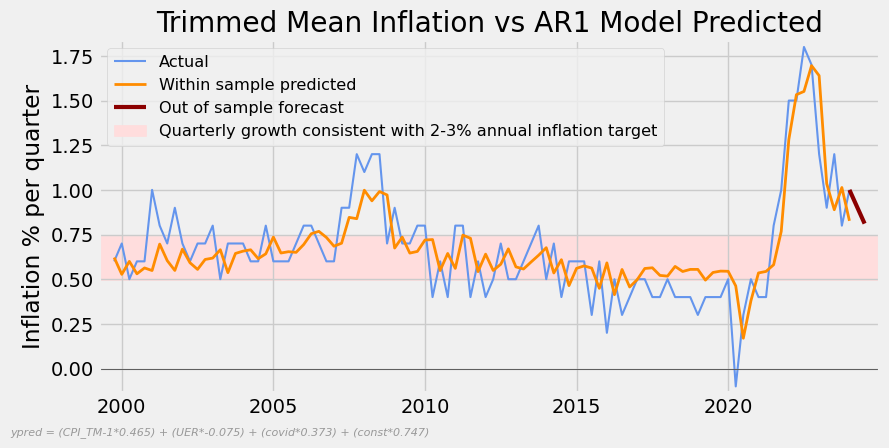

In [11]:
exog = ["CPI_TM-1", "UER", "covid", "const"]
title = "Trimmed Mean Inflation vs AR1 Model Predicted"
run_model(DATA, exog, title, ENDOG)

                                 OLS Regression Results                                
Dep. Variable:                 CPI_TM   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              289.1
Date:                Thu, 01 Aug 2024   Prob (F-statistic):                    2.03e-57
Time:                        13:28:00   Log-Likelihood:                          36.522
No. Observations:                  98   AIC:                                     -61.04
Df Residuals:                      92   BIC:                                     -45.53
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

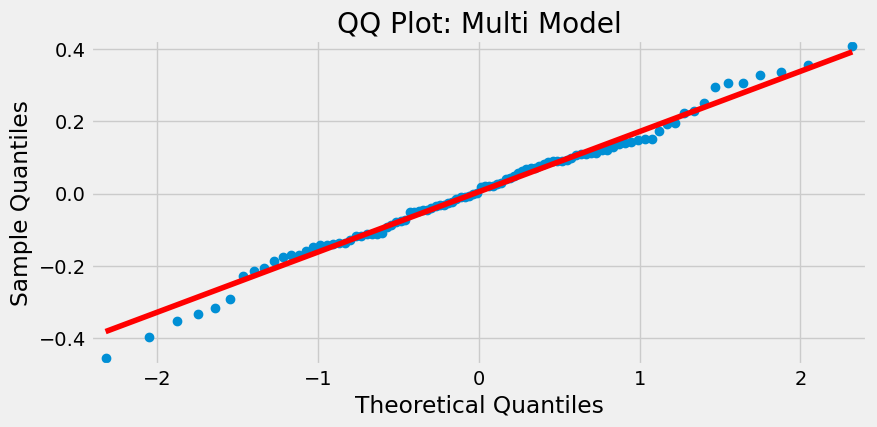

Forecasting using:


,CPI_TM-1,CPI_TM-2,ΔUER,PPI_HMA[7],WPI_HMA[7],covid
2024Q3,0.8,1.0,0.275,4.215075,3.975287,0.0


2024Q3    0.863239
Freq: Q-DEC, dtype: float64

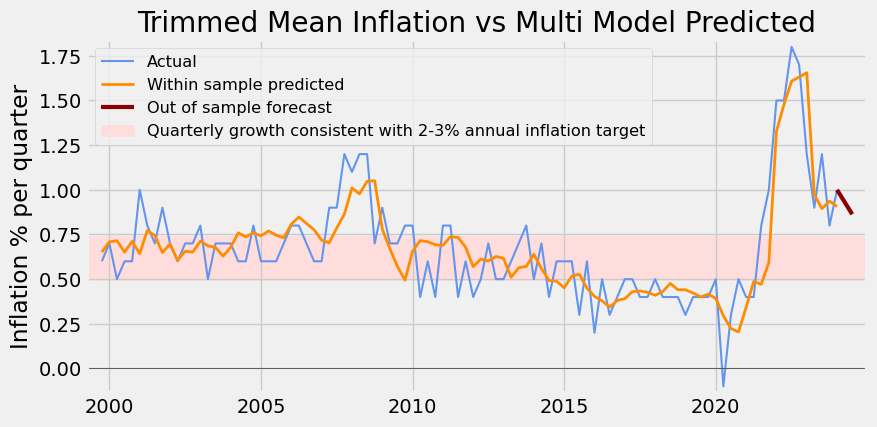

In [12]:
# Multi-model
# exog = ['CPI_TM-1', 'CPI_TM-2', "UER", "WPI_HMA[7]", "PPI_HMA[7]",  "const"]
# exog = ['CPI_TM-1', 'CPI_TM-2', "PPI_HMA[7]"]  # <-- the best model (no employment)
# exog = ['CPI_TM-1', 'CPI_TM-2', "WPI_HMA[7]"]
exog = ["CPI_TM-1", "CPI_TM-2", "ΔUER", "PPI_HMA[7]", "WPI_HMA[7]", "covid"]
title = "Trimmed Mean Inflation vs Multi Model Predicted"
run_model(DATA, exog, title, ENDOG)

In [13]:
# mean of all models
pd.Series(forecasts).mean()

0.8460978266565758

## Backtest

In [14]:
BACK_DATA = DATA.iloc[:-1]
BACK_INDEX = BACK_DATA.index[-1]
ACTUAL = BACK_DATA.iloc[-1, 0]
BACK_DATA.iloc[-1, 0] = None
BACK_DATA.tail(), BACK_INDEX

(        CPI_TM  PPI  WPI       UER  PPI_ADJ  WPI_ADJ  WPI_HMA[7]  PPI_HMA[7]  \
 2023Q1     1.2  4.9  3.6  3.610038      4.9      3.6    3.558881    4.900000   
 2023Q2     0.9  3.9  3.7  3.598759      3.9      3.7    3.770490    4.117343   
 2023Q3     1.2  3.8  4.0  3.683085      3.8      4.0    3.994126    3.880769   
 2023Q4     0.8  4.1  4.2  3.884424      4.1      4.2    4.117762    3.995734   
 2024Q1     NaN  4.3  4.1  3.893204      4.3      4.1    4.109752    4.151914   
 
         ΔPPI_ADJ  ΔWPI_ADJ  ΔUER  CPI_TM-1  CPI_TM-2  const  covid  
 2023Q1      -0.9      -0.9  -0.9       1.7       1.8    1.0    1.0  
 2023Q2      -1.0      -1.0  -1.0       1.2       1.7    1.0    0.0  
 2023Q3      -0.1      -0.1  -0.1       0.9       1.2    1.0    0.0  
 2023Q4       0.3       0.3   0.3       1.2       0.9    1.0    0.0  
 2024Q1       0.2       0.2   0.2       0.8       1.2    1.0    0.0  ,
 Period('2024Q1', 'Q-DEC'))

                                 OLS Regression Results                                
Dep. Variable:                 CPI_TM   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              281.4
Date:                Thu, 01 Aug 2024   Prob (F-statistic):                    1.77e-56
Time:                        13:28:00   Log-Likelihood:                          35.817
No. Observations:                  97   AIC:                                     -59.63
Df Residuals:                      91   BIC:                                     -44.19
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

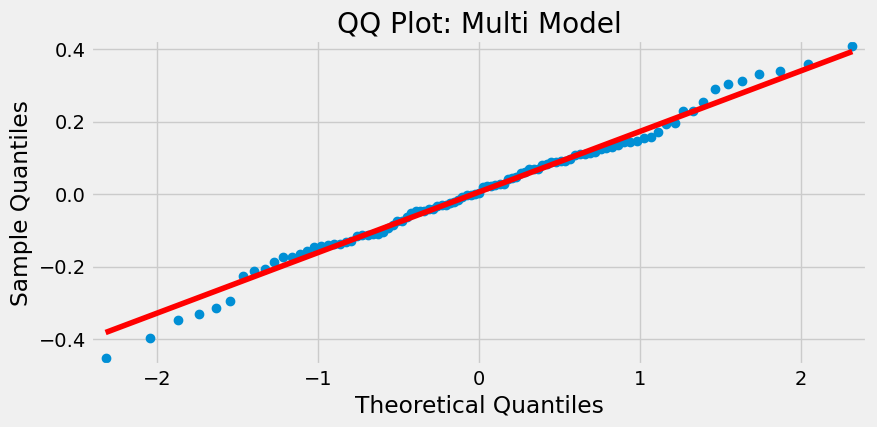

Forecasting using:


,CPI_TM-1,CPI_TM-2,ΔUER,PPI_HMA[7],WPI_HMA[7],covid
2024Q1,0.8,1.2,0.2,4.151914,4.109752,0.0


2024Q1    0.900364
Freq: Q-DEC, dtype: float64

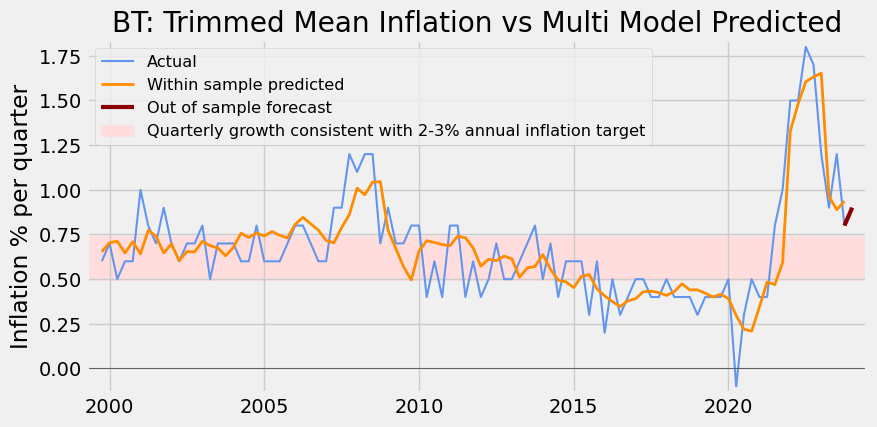

In [15]:
exog = ["CPI_TM-1", "CPI_TM-2", "ΔUER", "PPI_HMA[7]", "WPI_HMA[7]", "covid"]
title = "BT: Trimmed Mean Inflation vs Multi Model Predicted"
run_model(BACK_DATA, exog, title, ENDOG)

## Finished

In [16]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Aug 01 2024 13:28:01

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

readabs    : 0.0.17
pandas     : 2.2.2
statsmodels: 0.14.2
matplotlib : 3.9.1

Watermark: 2.4.3



In [17]:
print("Finished")

Finished
